In [1]:
# Standard library imports
import os
import sys

# Contributed library imports
import geopandas as gpd
import numpy as np
from pathlib import Path

# Our imports
from multiview_mapping_toolkit.meshes import TexturedPhotogrammetryMesh
from multiview_mapping_toolkit.utils.prediction_metrics import compute_and_show_cf
from multiview_mapping_toolkit.utils.geospatial import get_overlap_vector

sys.path.append("../..")
from constants_80m import (
    get_IDs_to_labels,
    get_numpy_export_cf_filename,
    get_predicted_vector_labels_filename,
    get_mesh_filename,
    get_camera_filename,
    get_DTM_filename,
    LABELS_COLUMN,
    LABELS_FILENAME,
)

/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set constants
You should be able to define most of the behavior from these constants

In [2]:
PREDICTION_SITE = "chips"
TRAINING_SITES = sorted(["delta", "lassic", "valley"])

In [3]:
## Parameters to control the outputs
# Repeat the labeling process
RETEXTURE = False
# Points less than this height (meters) above the DTM are considered ground
HEIGHT_ABOVE_GROUND_THRESH = 2
# The image is downsampled to this fraction for accelerated rendering
RENDER_IMAGE_SCALE = 0.25
# Cameras within this distance of the traing data are used in the rendering process
BUFFER_RADIUS_METERS = 50
# Downsample target
DOWNSAMPLE_TARGET = 1
# Image downsample factor for aggregation
AGGREGATE_IMAGE_SCALE = 0.25

/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

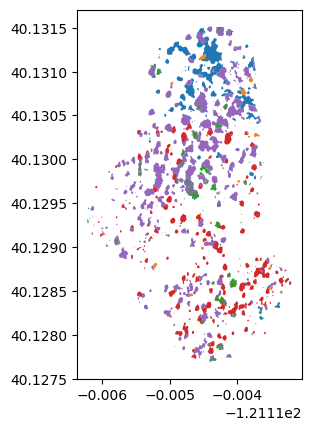

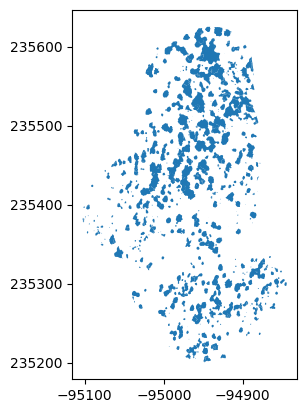

In [4]:
PREDICTED_VECTOR_LABELS_FILE = get_predicted_vector_labels_filename(PREDICTION_SITE, training_sites = TRAINING_SITES)

df = gpd.read_file(PREDICTED_VECTOR_LABELS_FILE)
df.plot("class_ID", cmap="tab10", vmin=-0.5, vmax=9.5)

class_fractions, IDs_in_original, unique_class_names = get_overlap_vector(
    unlabeled_df=LABELS_FILENAME,
    classes_df=PREDICTED_VECTOR_LABELS_FILE,
    class_column="class_ID",
)

[[1.92525649e-01 0.00000000e+00 0.00000000e+00 7.08220704e+00
  1.75739402e+00]
 [6.29747738e+00 9.25152555e-02 5.11334321e-01 3.72502935e+01
  7.77938019e+00]
 [2.36232981e-01 0.00000000e+00 2.47137306e+00 3.18802433e-01
  5.31825501e+01]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.75639063e+00
  1.11764538e+01]
 [2.67052679e+00 0.00000000e+00 4.67762986e-03 2.14061910e-02
  3.96207430e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.98963281e+00
  7.50123410e-02]]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 125 126 127 128
 12

/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

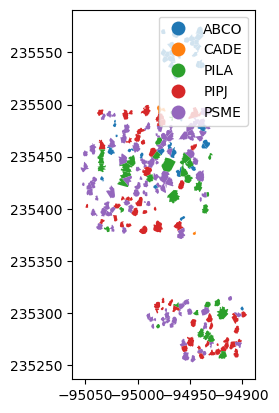

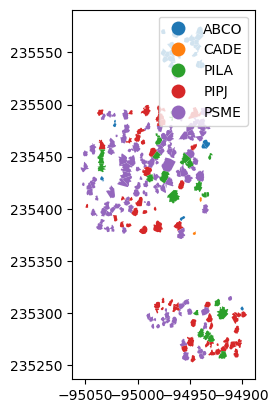

In [5]:
IDs_TO_LABELS = get_IDs_to_labels()

print(class_fractions)
print(IDs_in_original)
print(unique_class_names)
pred_IDs = np.argmax(class_fractions, axis=1)

pred_IDs = [int(unique_class_names[i]) for i in pred_IDs]
pred_class = [IDs_TO_LABELS[pred_ID] for pred_ID in pred_IDs]

# Load the data
gdf = gpd.read_file(LABELS_FILENAME)
site_gdf = gdf.iloc[IDs_in_original]
site_gdf["pred_class"] = pred_class
print("Ground truth")
site_gdf.plot(LABELS_COLUMN, legend=True, vmin=-0.5, vmax=9.5)
print("Predicted")
site_gdf.plot("pred_class", legend=True, vmin=-0.5, vmax=9.5)

GT classes ['CADE', 'PIPJ', 'PSME', 'PIPJ', 'PIPJ', 'PIPJ', 'PIPJ', 'PSME', 'ABCO', 'PSME', 'PSME', 'PILA', 'PIPJ', 'ABCO', 'PSME', 'PIPJ', 'PSME', 'ABCO', 'PSME', 'PSME', 'PSME', 'PSME', 'PSME', 'ABCO', 'PSME', 'PIPJ', 'PSME', 'PSME', 'PSME', 'PSME', 'PSME', 'ABCO', 'PSME', 'PSME', 'PIPJ', 'PSME', 'PSME', 'PSME', 'PIPJ', 'PILA', 'PIPJ', 'PSME', 'PSME', 'PIPJ', 'ABCO', 'ABCO', 'ABCO', 'PIPJ', 'PSME', 'PSME', 'PSME', 'ABCO', 'ABCO', 'PSME', 'ABCO', 'PIPJ', 'ABCO', 'PSME', 'PSME', 'PILA', 'ABCO', 'PILA', 'PILA', 'PILA', 'PSME', 'PILA', 'PILA', 'PSME', 'PSME', 'PSME', 'PSME', 'PILA', 'PILA', 'PILA', 'PSME', 'PILA', 'ABCO', 'PSME', 'ABCO', 'PILA', 'PIPJ', 'PILA', 'PSME', 'PSME', 'PSME', 'PILA', 'ABCO', 'PSME', 'PSME', 'PILA', 'PSME', 'PSME', 'PILA', 'PSME', 'PSME', 'PSME', 'PIPJ', 'PSME', 'PSME', 'PSME', 'ABCO', 'PILA', 'PSME', 'PSME', 'PSME', 'PSME', 'PSME', 'PSME', 'PILA', 'PSME', 'PSME', 'PILA', 'PSME', 'PIPJ', 'PIPJ', 'PIPJ', 'PSME', 'PIPJ', 'PSME', 'PSME', 'PSME', 'PIPJ', 'PIPJ', 'PSM

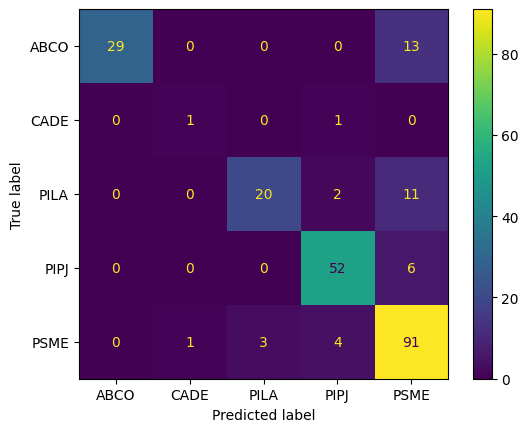

Accuracy: 0.8247863247863247


In [6]:
NUMPY_EXPORT_CONFUSION_MATRIX_FILE = get_numpy_export_cf_filename(PREDICTION_SITE, training_sites = TRAINING_SITES, is_ortho = False)

gt_list = site_gdf[LABELS_COLUMN].tolist()
pred_list = site_gdf["pred_class"].tolist()
print(f"GT classes {gt_list}")
print(f"Pred classes {pred_list}")

cf, classes, accuracy = compute_and_show_cf(
    pred_labels=pred_list,
    gt_labels=gt_list,
    labels=list(IDs_TO_LABELS.values()),
)
np.save(NUMPY_EXPORT_CONFUSION_MATRIX_FILE, cf)
print(f"Accuracy: {accuracy}")

# Ground truth classes

Loading transform to EPSG:4326


INFO:mesh_139963424200448:Loading transform to EPSG:4326


Loading mesh


INFO:mesh_139963424200448:Loading mesh


Reading the mesh


INFO:mesh_139963424200448:Reading the mesh


Selecting an ROI from mesh


INFO:mesh_139963424200448:Selecting an ROI from mesh


Standardizing ROI


INFO:mesh_139963424200448:Standardizing ROI


Dissolving ROI


INFO:mesh_139963424200448:Dissolving ROI


Setting CRS and buffering ROI


INFO:mesh_139963424200448:Setting CRS and buffering ROI


Dissolving buffered ROI


INFO:mesh_139963424200448:Dissolving buffered ROI


Extracting verts for dataframe


INFO:mesh_139963424200448:Extracting verts for dataframe


Checking intersection of verts with ROI


INFO:mesh_139963424200448:Checking intersection of verts with ROI


Extracting points from pyvista mesh


INFO:mesh_139963424200448:Extracting points from pyvista mesh


Extraction surface from subset mesh


INFO:mesh_139963424200448:Extraction surface from subset mesh


Extracting faces from mesh


INFO:mesh_139963424200448:Extracting faces from mesh


Loading texture


INFO:mesh_139963424200448:Loading texture


Could not read texture as a scalar from the pyvista mesh


Could not read texture as a numpy file


Sampling values from raster /ofo-share/scratch-derek/organized-str-disp-MVMT-experiments_80m/per_site_processing/chips/02_photogrammetry/exports/dtms/chips.tif: 100%|██████████| 520337/520337 [00:21<00:00, 24497.74it/s]


This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


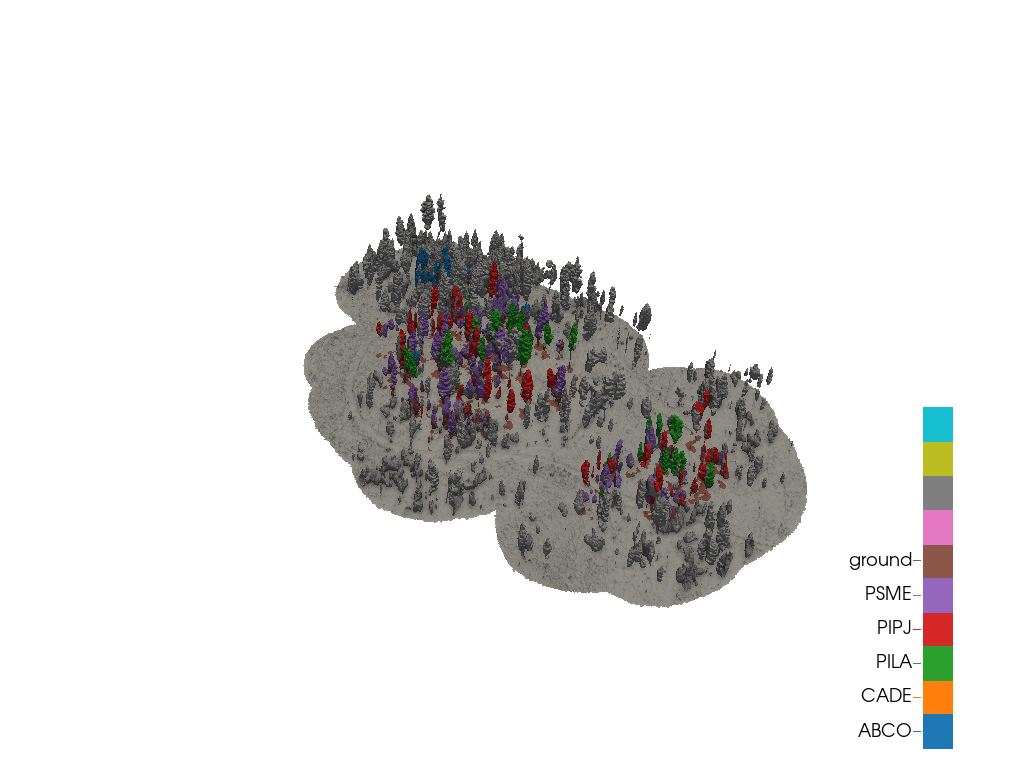

In [7]:
MESH_FILENAME = get_mesh_filename(PREDICTION_SITE)
CAMERAS_FILENAME = get_camera_filename(PREDICTION_SITE)
DTM_FILE = get_DTM_filename(PREDICTION_SITE)

mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=CAMERAS_FILENAME,
    texture=LABELS_FILENAME,
    texture_column_name=LABELS_COLUMN,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.label_ground_class(
    height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
    DTM_file=DTM_FILE,
    set_mesh_texture=True,
)
mesh.vis(force_xvfb=True)

# Predicted classes

In [8]:
NUMPY_EXPORT_FACES_TEXTURE_FILE= get_numpy_export_cf_filename(PREDICTION_SITE, training_sites = TRAINING_SITES, is_ortho = True)

mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=CAMERAS_FILENAME,
    texture=NUMPY_EXPORT_FACES_TEXTURE_FILE,
    IDs_to_labels=IDs_TO_LABELS,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.vis(force_xvfb=True)

Loading transform to EPSG:4326


INFO:mesh_139963425752736:Loading transform to EPSG:4326


Loading mesh


INFO:mesh_139963425752736:Loading mesh


Reading the mesh


INFO:mesh_139963425752736:Reading the mesh


Selecting an ROI from mesh


INFO:mesh_139963425752736:Selecting an ROI from mesh


Standardizing ROI


INFO:mesh_139963425752736:Standardizing ROI


Dissolving ROI


INFO:mesh_139963425752736:Dissolving ROI


Setting CRS and buffering ROI


INFO:mesh_139963425752736:Setting CRS and buffering ROI


Dissolving buffered ROI


INFO:mesh_139963425752736:Dissolving buffered ROI


Extracting verts for dataframe


INFO:mesh_139963425752736:Extracting verts for dataframe


Checking intersection of verts with ROI


INFO:mesh_139963425752736:Checking intersection of verts with ROI


Extracting points from pyvista mesh


INFO:mesh_139963425752736:Extracting points from pyvista mesh


Extraction surface from subset mesh


INFO:mesh_139963425752736:Extraction surface from subset mesh


Extracting faces from mesh


INFO:mesh_139963425752736:Extracting faces from mesh


Loading texture


INFO:mesh_139963425752736:Loading texture


Could not read texture as a scalar from the pyvista mesh


Could not read texture as a numpy file


ERROR:fiona._env:/ofo-share/scratch-derek/organized-str-disp-MVMT-experiments_80m/per_site_processing/chips/05_processed_predictions/chips_80m_delta_lassic_valley_model_ortho_confusion_matrix.npy: No such file or directory


DriverError: /ofo-share/scratch-derek/organized-str-disp-MVMT-experiments_80m/per_site_processing/chips/05_processed_predictions/chips_80m_delta_lassic_valley_model_ortho_confusion_matrix.npy: No such file or directory

# Colored mesh

In [ ]:
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=CAMERAS_FILENAME,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.vis(force_xvfb=True)